In [1]:
import uproot4 as upr
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import particle
import ROOT
import math
import numpy as np
import sys
import glob
sys.path.append('/storage/gpfs_data/neutrino/users/gi/sand-physics/notebook/python_tools')
from ROOT_tools import ROOT_tools
from MultiPlotter import MultiPlotter
from ROOT2Pandas import Converter
from SampleManager import Sample, Manager
tool = ROOT_tools()
import plotly.graph_objects as go

Welcome to JupyROOT 6.20/00


In [55]:
def plot_SAND3D(fig, opacity=0.4):
    # Parametri del cilindro
    sand_radius = 2000  # Raggio del cilindro
    sand_length = 3300  # Lunghezza del cilindro lungo X
    sand_center = [0, -2384.73, 23910]  # Il centro del cilindro nel piano YZ
    
    # Genera i punti per la superficie laterale del cilindro
    theta = np.linspace(0, 2 * np.pi, 100)  # Angolo attorno al cilindro
    x_sand = np.linspace(-sand_length / 2, sand_length / 2, 50) + sand_center[0]  # Lunghezza cilindro (asse X)
    theta, x = np.meshgrid(theta, x_sand)  # Griglia 2D per la superficie laterale

    # Coordinate nel piano ZY per la superficie laterale
    z_sand = sand_radius * np.cos(theta) + sand_center[2]  # Coordinata Z della circonferenza del cilindro
    y_sand = sand_radius * np.sin(theta) + sand_center[1]  # Coordinata Y della circonferenza del cilindro

    # Genera i punti per i tappi (dischi) alle estremità
    theta_cap = np.linspace(0, 2 * np.pi, 100)  # Angolo per i tappi
    r_cap = np.linspace(0, sand_radius, 50)  # Raggio dei tappi
    theta_cap, r = np.meshgrid(theta_cap, r_cap)  # Griglia 2D per i tappi

    # Coordinate dei tappi nel piano ZY, con X fisso a +sand_length/2 e -sand_length/2
    x_cap_top = np.full_like(theta_cap, sand_length / 2) + sand_center[0]  # Tappo superiore, X fisso
    x_cap_bottom = np.full_like(theta_cap, -sand_length / 2) + sand_center[0]  # Tappo inferiore, X fisso

    # Coordinate ZY per i tappi (dischi)
    z_cap = r * np.cos(theta_cap) + sand_center[2]  # Coordinata Z per i tappi
    y_cap = r * np.sin(theta_cap) + sand_center[1]  # Coordinata Y per i tappi

    # Plotta la superficie laterale del cilindro
    fig.add_surface(x=x, y=z_sand, z=y_sand, colorscale='Blues', opacity=opacity, showscale=False)

    # Plotta il tappo superiore (a X = +sand_length/2)
    fig.add_surface(x=x_cap_top, y=z_cap, z=y_cap, colorscale='Blues', opacity=opacity, showscale=False)

    # Plotta il tappo inferiore (a X = -sand_length/2)
    fig.add_surface(x=x_cap_bottom, y=z_cap, z=y_cap, colorscale='Blues', opacity=opacity, showscale=False)

    # Imposta le etichette degli assi e il range, mantenendo il rapporto proporzionale tra gli assi
    fig.update_layout(
        scene=dict(
            xaxis_title='X',  # L'asse X rappresenta la lunghezza del cilindro
            yaxis_title='Z',  # L'asse Z rappresenta la circonferenza del cilindro nel piano ZY
            zaxis_title='Y',  # L'asse Y rappresenta la circonferenza del cilindro nel piano ZY
            aspectmode='manual',  # Mantenere il rapporto proporzionale tra gli assi
            aspectratio=dict(x=0.8, y=1, z=1),  # Regola il rapporto per rendere l'asse X più corto
            xaxis=dict(range=[-sand_length / 2 - 500, sand_length / 2 + 500]),  # Range asse X (lunghezza del cilindro)
            yaxis=dict(range=[sand_center[2] - sand_radius - 500, sand_center[2] + sand_radius + 500]),  # Range asse Z
            zaxis=dict(range=[sand_center[1] - sand_radius - 500, sand_center[1] + sand_radius + 500])  # Range asse Y
        ),
        width=800,
        height=600
    )

def GetExpectedTrajectory(vtx, direction, nof_points = 5000):
    direction = direction / np.sqrt(direction[0]**2 + direction[1]**2 + direction[2]**2)
    x,y,z = [],[],[]
    for i in range(nof_points):
        x.append(vtx[0] + i*direction[0])
        y.append(vtx[1] + i*direction[1])
        z.append(vtx[2] + i*direction[2])
    return {"x":x,"y":y,"z":z}

def plot_track3D(fig, vector_x, vector_y, vector_z, label = '', color = 'blue', style = 'dash', line_width=3):
    fig.add_trace(go.Scatter3d(
        x = vector_x, 
        y = vector_z, 
        z = vector_y,
        mode='lines', 
        name=label, 
        line=dict(color=color, 
                  dash=style, 
                  width=line_width)  # Aggiunto il parametro width
    ))

def plot_points3D(fig, vector_x, vector_y, vector_z, label = '', color = 'blue', symbol = 'cross', size = 5):
    fig.add_trace(go.Scatter3d(
    x=vector_x, 
    y=vector_y, 
    z=vector_z,
    mode='markers',  # Cambia da 'lines' a 'markers'
    name=label, 
    marker=dict(
        color=color,
        symbol=symbol,  # Imposta il simbolo come croce
        size=size,  # Imposta la dimensione dei marker
        line=dict(width=2, color=color),
        opacity=0.8
    )
))

def plot_event3D(df_selected_bkg,
                   file_selected_background:str,
                   fired_cells,
                   random_spill_trajectory_points,
                   spill_number:int, plot_hit_reco = True, plot_hit_true = False):
    event = df_selected_bkg.loc[file_selected_background]
    print("Calculate expected neutron")
    predicted_neutron = GetExpectedTrajectory([event.Interaction_vtxX * 1e3, event.Interaction_vtxY * 1e3, event.Interaction_vtxZ * 1e3],
                      [event.PredictedNeutron_P3_GeVfX, event.PredictedNeutron_P3_GeVfY, event.PredictedNeutron_P3_GeVfZ])
    print("read event trajectories")
    # event_trajectory = trajectories.loc[event_name]
    event_random_trajectories = random_spill_trajectory_points.loc[0]
    print("read fired wires")
    event_fired_cells = fired_cells.loc[spill_number]
    # compatible_cell = event_fired_cells.query("IsCompatible==1")

    # track_ids_event = event_trajectory.trackid.unique()
    labels = {2112:"neutron", 22:"gamma", -13:"antimuons", -11:"positron", 11:"electron"}
    colors = {2112:"blue", 22:"violet", -13:"green", -11:"violet", 11:"violet"}

    print(event)

    # Crea il grafico interattivo con Plotly
    fig = go.Figure()

    for trackid in event_random_trajectories[event_random_trajectories.trackid!=-999].trackid.unique():

        plot_track3D(fig, event_random_trajectories.query(f"trackid == {trackid}").point_x, 
                          event_random_trajectories.query(f"trackid == {trackid}").point_y, 
                          event_random_trajectories.query(f"trackid == {trackid}").point_z, 
                        #   label=labels[event_random_trajectories.query(f"pdg_name == {pdg}").pdg_name.unique()[0]],
                        #   color=colors[event_random_trajectories.query(f"pdg_name == {pdg}").pdg_name.unique()[0]],
                          style='solid',
                          line_width=2.5)

    plot_track3D(fig, predicted_neutron['x'], 
                      predicted_neutron['y'], 
                      predicted_neutron['z'], 
                      label="predicted neutron",
                      color='blue',
                      style='dash',
                      line_width=5)

    # plot_track3D(fig, antimu_trj.point_x, 
    #                   antimu_trj.point_y, 
    #                   antimu_trj.point_z, 
    #                   label="true antimu",
    #                   color='green',
    #                   style='solid',
    #                   line_width=5)

    # plot_points3D(fig, event_fired_cells.ExpectedNeutron_HitPosition_x_,
    #                    event_fired_cells.ExpectedNeutron_HitPosition_z_,
    #                    event_fired_cells.ExpectedNeutron_HitPosition_y_,
    #                    label='predicted hits',
    #                    color='blue',
    #                    size = 8)
    if(plot_hit_reco==1):
            plot_points3D(fig, event_fired_cells.reco_hit_x,
                           event_fired_cells.reco_hit_z,
                           event_fired_cells.reco_hit_y,
                           label='ECAL hit reco',
                           color='orange',
                           size = 8)
    
    if(plot_hit_true == True):
            plot_points3D(fig, event_fired_cells.true_hit1_x,
                           event_fired_cells.true_hit1_z,
                           event_fired_cells.true_hit1_y,
                           label='ECAL hit true',
                           color='violet',
                           size = 8)

    # plot_points3D(fig, compatible_cell.Reconstructed_HitPosition_x,
    #                    compatible_cell.Reconstructed_HitPosition_z,
    #                    compatible_cell.Reconstructed_HitPosition_y,
    #                    label='compatible cell',
    #                    color='red',
    #                    size = 8)

    plot_SAND3D(fig)

    # fig.write_html('grafico_interattivo.html')

    fig.update_layout(
        width=1e3,  # Imposta la larghezza
        height=1e3  # Imposta l'altezza
    )
    fig.show()

In [2]:
pdg_to_name = {
    12: "neutrino_e",
    14: "neutrino_mu",
    13: "muon",
    13: "muon",
    2112: "neutron",
    2212: "proton",
    211: "pi+-",
    111: "pi0",
    22: "photon",
    11: "e+-",
    311: "K0",
    321: "K+-",
    213: "rho+-",
}

def pdg_to_particle_name(pdg_series):
    return pdg_series.map(pdg_to_name).fillna("other")

def Tuple2String(input_column: tuple) -> str:
    """
    Parse input column (tuple) and return a short name.
    
    Example:
    ('PrimariesFirstHitECAL', 'fP', 'fX') -> PrimariesFirstHitECAL_x
    ('PrimariesFirstHitECAL', 'fE', '')   -> PrimariesFirstHitECAL_t
    """
    colName, suffix1, suffix2 = input_column
    if suffix1 == 'fP':
        if suffix2 == 'fX':
            return colName + "_x"
        elif suffix2 == 'fY':
            return colName + "_y"
        elif suffix2 == 'fZ':
            return colName + "_z"
        else:
            return colName
    elif suffix1 == 'fE':
        return colName + "_t"
    else:
        return colName

In [3]:
file_trj = "/storage/gpfs_data/neutrino/users/gi/sand-physics/production_spill_reverse_volSAND/SAND_opt3_DRIFT1_reverse_volSAND/sand-drift-events.0.to.10.analysed.trj.root"
file_trj_points = "/storage/gpfs_data/neutrino/users/gi/sand-physics/production_spill_reverse_volSAND/SAND_opt3_DRIFT1_reverse_volSAND/sand-drift-events.0.to.10.analysed.trj_points_spill.root"
file_cells = "/storage/gpfs_data/neutrino/users/gi/sand-physics/production_spill_reverse_volSAND/SAND_opt3_DRIFT1_reverse_volSAND/sand-drift-events.0.to.10.analysed.cells.root"

In [4]:
converter_trj = Converter([file_trj], "trajectories")
converter_trj_points = Converter([file_trj_points], "trajectories_points")
converter_cells = Converter([file_cells], "cells")

In [5]:
columns_trajectories = [
    "trajectories_spill_number",
    "trajectories_id",
    "trajectories_pdg",
    # "trajectories_name",
    # "trajectories_starting_volume",
    "trajectories_ecal_edep",
    "trajectories_earliest_hit_ecal",
    "trajectories_latest_hit_ecal",
    "trajectories_TOF2ECAL",
]

columns_cells = [
    # "file_name",
    "spill_number",
    "cell_mod",
    "cell_id",
    "cell_x",
    "cell_y",
    "cell_z",
    "is_complete",
    "track_id_pmt1_hit",
    "track_id_pmt2_hit",
    "track_pdg_pmt1_hit",
    "track_pdg_pmt2_hit",
    "true_hit1",
    "true_hit2",
    "true_edep1",
    "true_edep2",
    "reco_hit",
    "reco_edep",
]
columns_trajectories_points =[

    # "file_name",
    # "trajectories_starting_volume",
    # "trajectories_ecal_edep",
    # "trajectories_TOF2ECAL",
    "trackid",
    "pdg",
    "point_x",
    "point_y",
    "point_z",
    # "point_px",
    # "point_py",
    # "point_pz",
    # "process",
]

In [6]:
random_spill_trajectory_points = converter_trj_points.CreatePandas(
    columns = columns_trajectories_points,
    rename = False,
    # indices = ['entry','subentry']
)
# .droplevel(level=2).rename_axis(index={'entry': 'spill', 'subentry': 'index'})

random_spill_trajectory_points = random_spill_trajectory_points.rename_axis(index={'entry': 'spill', 'subentry': 'index'})
random_spill_trajectory_points

trackid  pdg      point_x      point_y       point_z
spill index                                                      
0     0            0   13   594.410936 -3430.433643  23725.094274
      1            0   13   590.003925 -3427.364318  23754.689095
      2            0   13   589.734311 -3427.178510  23756.500000
      3            0   13   589.731334 -3427.176455  23756.520000
      4            0   13   586.003158 -3424.616535  23781.580000
...              ...  ...          ...          ...           ...
89    56211     6750   11 -1149.933938 -1963.499821  21744.014260
      56212     6750   11 -1150.069976 -1965.029213  21746.098318
      56213     6750   11 -1149.273882 -1965.593036  21745.901411
      56214     6750   11 -1149.255948 -1964.827663  21745.887121
      56215     6750   11 -1151.578197 -1963.602542  21745.268547

[3699700 rows x 5 columns]

In [7]:
random_spill_trajectory_points['pdg_name'] = pdg_to_particle_name(abs(random_spill_trajectory_points['pdg']))

In [8]:
cells = converter_cells.CreatePandas(
    columns = columns_cells,
    rename = True,
    indices = ['entry','subentry']
).droplevel(level=2).rename_axis(index={'entry': 'spill', 'subentry': 'index'})

cells

DataFrame from file /storage/gpfs_data/neutrino/users/gi/sand-physics/production_spill_reverse_volSAND/SAND_opt3_DRIFT1_reverse_volSAND/sand-drift-events.0.to.10.analysed.cells.root has MultiIndex structure, keeping entry and subentry as columns


spill_number  cell_mod  cell_id        cell_x   cell_y  \
spill index                                                           
0     0                 6        40   140002 -1.712000e+03 -2384.73   
      1                 6        40   140003 -1.712000e+03 -2384.73   
      2                 6        40   140011 -1.712000e+03 -2384.73   
      3                 6        40   140110 -1.756000e+03 -2384.73   
      4                 6         0   200005  4.696243e-13  -362.73   
...                   ...       ...      ...           ...      ...   
89    831               8        30   330402  1.893000e+03 -2384.73   
      832               8        30   330404  1.893000e+03 -2384.73   
      833               8        30   330405  1.893000e+03 -2384.73   
      834               8        30   330406  1.893000e+03 -2384.73   
      835               8        30   330407  1.893000e+03 -2384.73   

                   cell_z  is_complete  track_id_pmt1_hit  track_id_pmt2_hit  \
spill index                                                                    
0     0      22021.111111            1                334                334   
      1      22065.555556            0                334                334   
      2      22421.111111            1                334                334   
      3      22376.666667            1                334                334   
      4      23932.120688            1                130                130   
...                   ...          ...                ...                ...   
89    831    25798.888889            1                169                169   
      832    25710.000000            1                 34                 34   
      833    25665.555556            0                 34                 34   
      834    25621.111111            1                416                416   
      835    25576.666667            1                 59                 59   

             track_pdg_pmt1_hit  ...  true_hit2_y   true_hit2_z  true_hit2_t  \
spill index                      ...                                           
0     0                     211  ... -2655.906965  22027.419432  7080.948511   
      1                     211  ...  -999.000000   -999.000000  -999.000000   
      2                     211  ... -2401.103454  22402.384452  7149.294908   
      3                     211  ... -2397.070657  22382.690335  7156.808452   
      4                      22  ...  -380.934529  23934.023039  3922.552772   
...                         ...  ...          ...           ...          ...   
89    831                  2112  ... -2236.487863  25786.709814  3512.324511   
      832                  2112  ... -1740.980223  25698.561001  2251.686511   
      833                  2112  ...  -999.000000   -999.000000  -999.000000   
      834                   211  ... -2444.574364  25602.856287  6475.969764   
      835                  2112  ... -1403.769025  25584.350224  2017.201463   

             true_edep1  true_edep2   reco_hit_x   reco_hit_y    reco_hit_z  \
spill index                                                                   
0     0        1.077140    1.077140 -1712.000000 -2375.405400  22021.111111   
      1     -999.000000 -999.000000  -999.000000  -999.000000   -999.000000   
      2        0.699242    0.699242 -1712.000000 -2342.083249  22421.111111   
      3        0.330639    0.330639 -1756.000000 -2412.948283  22376.666667   
      4        0.115499    0.115499    87.062821  -362.730000  23932.120688   
...                 ...         ...          ...          ...           ...   
89    831      0.062382    0.062382  1893.000000 -2451.448497  25798.888889   
      832      0.223657    0.223657  1893.000000 -2288.019049  25710.000000   
      833   -999.000000 -999.000000  -999.000000  -999.000000   -999.000000   
      834      0.289397    0.289397  1893.000000 -2297.669893  25621.111111   
      835      0.451562    0.451562  1893.000000 -2276.6971

In [9]:
cells = cells[cells.track_id_pmt1_hit == cells.track_id_pmt2_hit]

In [10]:
cells['track_pdg_pmt1_hit'] = pdg_to_particle_name(abs(cells['track_pdg_pmt1_hit']))

/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [11]:
cells_manager = Manager(cells, "cells", reference_index="spill")

In [12]:
cells_manager.DefineSample("cells_fired_by_one_trajectory", "track_id_pmt1_hit == track_id_pmt2_hit")
cells_manager.DefineSample("cells_fired_by_neutron", "(track_id_pmt1_hit == track_id_pmt2_hit) & (track_pdg_pmt2_hit == 2112)")
cells_manager.DefineSample("cells_fired_by_neutron_filter", "(track_id_pmt1_hit == track_id_pmt2_hit) & (track_pdg_pmt2_hit == 2112) & (is_complete == 1) & (true_edep1 > 0.10)")

In [13]:
cells_fired_by_one_trajectory = cells_manager.GetSample("cells_fired_by_one_trajectory")
cells_fired_by_neutron = cells_manager.GetSample("cells_fired_by_neutron")
cells_fired_by_neutron_filter = cells_manager.GetSample("cells_fired_by_neutron_filter")

In [15]:
cells_fired_by_neutron_filter.dataframe

spill_number  cell_mod  cell_id        cell_x       cell_y  \
spill index                                                               
0     5                 6         0   200010  4.696243e-13  -362.730000   
      8                 6         0   200311  4.696243e-13  -230.730000   
      17                6         0   200411  4.696243e-13  -181.730000   
      18                6         1   201002  4.536223e-13  -391.551191   
      19                6         1   201102  4.536223e-13  -348.175309   
...                   ...       ...      ...           ...          ...   
89    768               8        22   222304  4.067066e-13  -554.666009   
      778               8        22   222405  4.067066e-13  -488.929912   
      816               8        23   223403  4.536223e-13  -287.993134   
      832               8        30   330404  1.893000e+03 -2384.730000   
      835               8        30   330407  1.893000e+03 -2384.730000   

                   cell_z  is_complete  track_id_pmt1_hit  track_id_pmt2_hit  \
spill index                                                                    
0     5      23710.913804            1                211                211   
      8      23650.731993            1                211                211   
      17     23644.814710            1                211                211   
      18     23536.236500            1                211                211   
      19     23528.114552            1                211                211   
...                   ...          ...                ...                ...   
89    768    25048.236186            1                 26                 26   
      778    25032.377927            1                385                385   
      816    24596.609866            1                 38                 38   
      832    25710.000000            1                 34                 34   
      835    25576.666667            1                 59                 59   

            track_pdg_pmt1_hit  ...  true_hit2_y   true_hit2_z  true_hit2_t  \
spill index                     ...                                           
0     5                neutron  ...  -345.889741  23718.622319  5374.153940   
      8                neutron  ...  -247.684380  23670.127402  5367.023858   
      17               neutron  ...  -186.189703  23621.778883  5365.565509   
      18               neutron  ...  -378.919897  23515.130432  5383.097539   
      19               neutron  ...  -374.539191  23512.549955  5383.635963   
...                        ...  ...          ...           ...          ...   
89    768              neutron  ...  -565.319247  25058.115565  1549.348873   
      778              neutron  ...  -495.699682  25036.928240  5772.566335   
      816              neutron  ...  -265.582852  24593.229455  1987.490202   
      832              neutron  ... -1740.980223  25698.561001  2251.686511   
      835              neutron  ... -1403.769025  25584.350224  2017.201463   

             true_edep1  true_edep2   reco_hit_x   reco_hit_y    reco_hit_z  \
spill index                                                                   
0     5        1.729350    1.729350    -3.759150  -362.730000  23710.913804   
      8       10.558143   10.558143    -1.040791  -230.730000  23650.731993   
      17       2.988274    2.988274   -11.656412  -181.730000  23644.814710   
      18       0.134528    0.133671    -8.896519  -391.551191  23536.236500   
      19       0.157696    0.157696    13.201208  -348.175309  23528.114552   
...                 ...         ...          ...          ...           ...   
89    768      0.691600    0.691600   -19.832835  -554.666009  25048.236186   
      778      0.269209    0.269209    99.257517  -488.929912  25032.377927   
      816      0.269581    0.269581   -13.332752  -287.993134  24596.609866   
      832      0.223657    0.223657  1893.000000 -2288.019049  25710.000000   
      835      0.451

In [16]:
grouped_df = cells_fired_by_one_trajectory.dataframe.groupby(["spill", "track_pdg_pmt1_hit"]).size().reset_index(name='nof_cells_fired')
grouped_df

spill track_pdg_pmt1_hit  nof_cells_fired
0        0                K+-                6
1        0                e+-                2
2        0               muon              242
3        0            neutron              150
4        0              other                4
..     ...                ...              ...
600     89            neutron              339
601     89              other               92
602     89             photon              129
603     89               pi+-              121
604     89             proton               40

[605 rows x 3 columns]

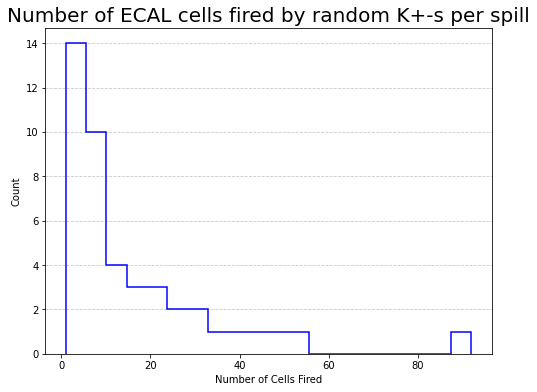

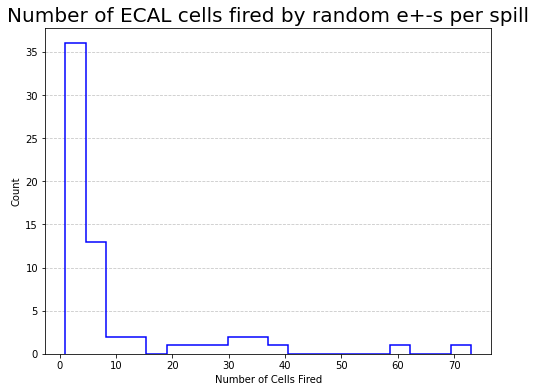

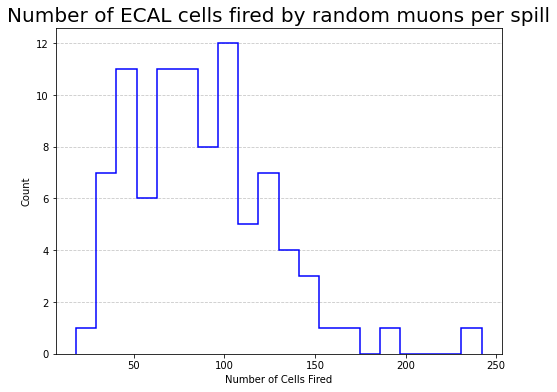

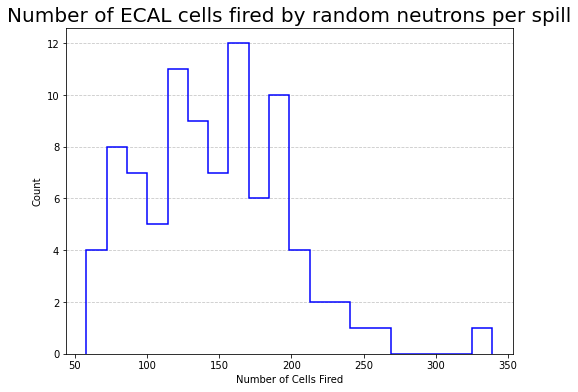

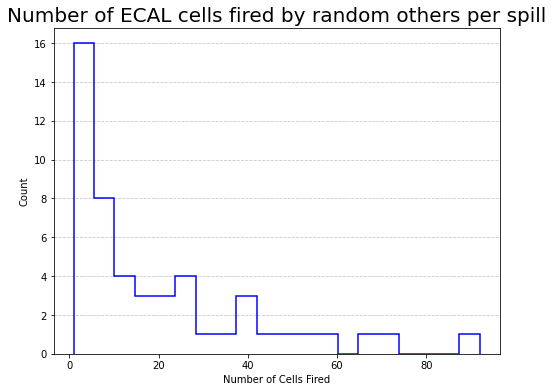

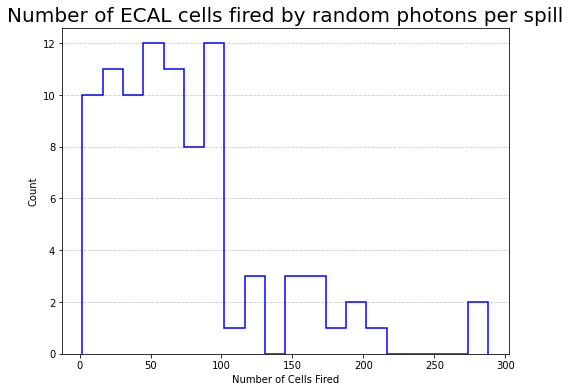

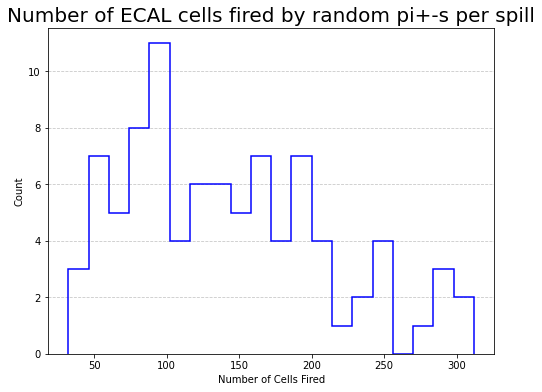

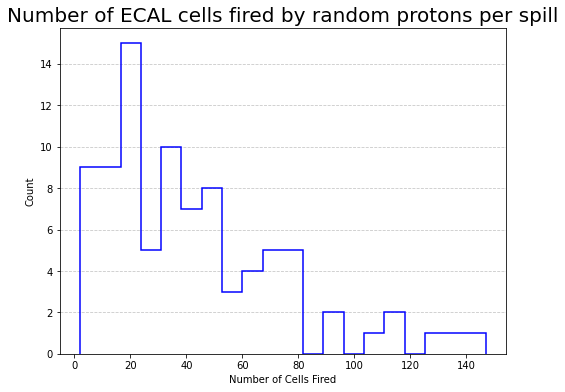

In [17]:
# Ottieni le categorie uniche
unique_categories = grouped_df['track_pdg_pmt1_hit'].unique()

# Cicla su ciascuna categoria e plotta un istogramma
for category in unique_categories:
    # Filtra i dati per la categoria corrente
    category_data = grouped_df[grouped_df['track_pdg_pmt1_hit'] == category]['nof_cells_fired']
    
    # Crea un nuovo grafico per ogni categoria
    plt.figure(figsize=(8, 6))
    plt.hist(category_data, bins=20, histtype='step', color='blue', linewidth=1.5)
    plt.title(f"Number of ECAL cells fired by random {category}s per spill", fontsize=20)
    plt.xlabel("Number of Cells Fired")
    plt.ylabel("Count")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()



# selected background

In [18]:
folder = "/storage/gpfs_data/neutrino/users/gi/sand-physics/production_antinumucc/Selections/Wires_cut_multi1"
production_files = glob.glob(f"{folder}/*selected_bkg.root")
trajectories_files = glob.glob(f"{folder}/*selected_bkg.trj.root")
production_files

['/storage/gpfs_data/neutrino/users/gi/sand-physics/production_antinumucc/Selections/Wires_cut_multi1/events-in-SANDtracker.4400.to.4500.selected_bkg.root',
 '/storage/gpfs_data/neutrino/users/gi/sand-physics/production_antinumucc/Selections/Wires_cut_multi1/events-in-SANDtracker.1300.to.1400.selected_bkg.root',
 '/storage/gpfs_data/neutrino/users/gi/sand-physics/production_antinumucc/Selections/Wires_cut_multi1/events-in-SANDtracker.4500.to.4600.selected_bkg.root',
 '/storage/gpfs_data/neutrino/users/gi/sand-physics/production_antinumucc/Selections/Wires_cut_multi1/events-in-SANDtracker.4900.to.5000.selected_bkg.root',
 '/storage/gpfs_data/neutrino/users/gi/sand-physics/production_antinumucc/Selections/Wires_cut_multi1/events-in-SANDtracker.900.to.1000.selected_bkg.root',
 '/storage/gpfs_data/neutrino/users/gi/sand-physics/production_antinumucc/Selections/Wires_cut_multi1/events-in-SANDtracker.3100.to.3200.selected_bkg.root',
 '/storage/gpfs_data/neutrino/users/gi/sand-physics/product

In [19]:
columns_trj = [
    "FileName",
    "CCQEonHydrogen",
    "NuDirection",
    "Interaction_vtxX",
    "Interaction_vtxY",
    "Interaction_vtxZ",
    "Interaction_vtxT",
    "PrimaryStateHadronicSystemTopology_name",
    "PredictedNeutron_P3_GeV",
    "Antimuon_reconstructed_P4",
    #
    "trackid",
    "pdg",
    "point_x",
    "point_y",
    "point_z",
    "point_px",
    "point_py",
    "point_pz",
    "process",
]

columns_fired_Cells = [
    "FileName",
    "CCQEonHydrogen",
    # /*
    #     CELL INFOS
    # */
    'Fired_Cells_mod',
    'Fired_Cells_id',
    'Fired_Cells_x',
    'Fired_Cells_y',
    'Fired_Cells_z',
    'isCellComplete',
    'Fired_Cells_adc1',
    'Fired_Cells_tdc1',
    'Fired_Cells_adc2',
    'Fired_Cells_tdc2',
    'Fired_Cell_true_hit1',
    'Fired_Cell_true_hit2',
     "Fired_by_primary_neutron",
     "Fired_by_primary_antimu",
    # /*
    #     TRUE NEUTRON HITS
    # */
    "Fired_Cell_true_Hit_x",
    "Fired_Cell_true_Hit_y",
    "Fired_Cell_true_Hit_z",
    "Fired_Cell_true_Hit_t",
    "Fired_Cell_true_Hit_e",
    "True_FlightLength",
    # /*
    #     PREDICTED NEUTRON HITS
    # */
    "ExpectedNeutron_HitPosition_x_",
    "ExpectedNeutron_HitPosition_y_",
    "ExpectedNeutron_HitPosition_z_",
    "ExpectedNeutron_FlightLength_",
    "ExpectedNeutron_TOF_",
    "Expected_HitTime_",
    # /*
    #     RECONSTRUCTED NEUTRON HITS
    # */
    "Reconstructed_HitPosition_x",
    "Reconstructed_HitPosition_y",
    "Reconstructed_HitPosition_z",
    "Reconstructed_HitTime",
    "Reconstructed_Energy",
    "IsEarliestCell_neutron",
    "Reconstructed_FlightLength",
    # /*
    #     CELLS WITH COINCIDENCES
    # */
   "Residuals_HitTime_",
   "Residuals_HitSpace_",
   "IsCompatible",
   "earliest_compatible_cell",
   "nof_compatible_cells",
]

columns_df = [
    "FileName",
    "CCQEonHydrogen",
    "EventType",
    "NuDirection",
    "Interaction_vtxX",
    "Interaction_vtxY",
    "Interaction_vtxZ",
    "Interaction_vtxT",
    "InteractionVolume_short",
    "NofFinalStateChargedParticles",
    "PrimaryStateHadronicSystemTopology_name",
    "InteractionTarget",
    "candidate_signal_event",
    "nof_fired_wires",
    "PredictedNeutron_P3_GeV",
    "FinalStateHadronicSystemTotal4Momentum", # true neutron
    "Antimuon_p_true", # true antimuon
    "reconstructed_neutron_KinE_MeV",
    "Neutrino_reconstructed_P4_GeV",
]

In [20]:
converter_trj = Converter(trajectories_files, "traj")
converter = Converter(production_files, "selected_bkg")

In [21]:
trajectories_selected_bkg = converter_trj.CreatePandas(
    columns = columns_trj,
    rename = True,
    indices = ['FileName']
)
trajectories_selected_bkg

DataFrame from file /storage/gpfs_data/neutrino/users/gi/sand-physics/production_antinumucc/Selections/Wires_cut_multi1/events-in-SANDtracker.5800.to.5900.selected_bkg.trj.root has MultiIndex structure, keeping entry and subentry as columns


entry  \
FileName                                           subentry          
events-in-SANDtracker.5825.gtrac.root:gRooTrack... 0             0   
                                                   1             0   
                                                   2             0   
                                                   3             0   
                                                   4             0   
...                                                            ...   
events-in-SANDtracker.5822.gtrac.root:gRooTrack... 37         6694   
                                                   38         6694   
                                                   39         6694   
                                                   40         6694   
                                                   41         6694   

                                                             CCQEonHydrogen  \
FileName                                           subentry                   
events-in-SANDtracker.5825.gtrac.root:gRooTrack... 0                      0   
                                                   1                      0   
                                                   2                      0   
                                                   3                      0   
                                                   4                      0   
...                                                                     ...   
events-in-SANDtracker.5822.gtrac.root:gRooTrack... 37                     0   
                                                   38                     0   
                                                   39                     0   
                                                   40                     0   
                                                   41                     0   

                                                             NuDirectionfX  \
FileName                                           subentry                  
events-in-SANDtracker.5825.gtrac.root:gRooTrack... 0             -0.000960   
                                                   1             -0.000960   
                                                   2             -0.000960   
                                                   3             -0.000960   
                                                   4             -0.000960   
...                                                                    ...   
events-in-SANDtracker.5822.gtrac.root:gRooTrack... 37             0.000781   
                                                   38             0.000781   
                                                   39             0.000781   
                                                   40             0.000781   
                                                   41             0.000781   

                                                             NuDirectionfY  \
FileName                                           subentry                  
events-in-SANDtracker.5825.gtrac.root:gRooTrack... 0             -0.098715   
                                                   1             -0.098715   
                                                   2             -0.098715   
                                                   3             -0.098715   
                                                   4             -0.098715   
...                                                                    ...   
events-in-SANDtracker.5822.gtrac.root:gRooTrack... 37            -0.101851   
                                                   38            -0.101851   
                                                   39            -0.101851   
                                                   40            -0.101851   
                                                   41            -0.101851   

                                                             NuDirectionfZ  \
FileName      

In [22]:
selected_bkg = converter.CreatePandas(
    columns = columns_df,
    rename = True,
    indices = ['FileName']
)
selected_bkg

CCQEonHydrogen EventType  \
                                                                              
                                                                              
FileName                                                                      
events-in-SANDtracker.4400.gtrac.root:gRooTrack...              0       QES   
events-in-SANDtracker.4400.gtrac.root:gRooTrack...              1       QES   
events-in-SANDtracker.4400.gtrac.root:gRooTrack...              1       QES   
events-in-SANDtracker.4400.gtrac.root:gRooTrack...              0       RES   
events-in-SANDtracker.4400.gtrac.root:gRooTrack...              0       QES   
...                                                           ...       ...   
events-in-SANDtracker.5899.gtrac.root:gRooTrack...              1       QES   
events-in-SANDtracker.5899.gtrac.root:gRooTrack...              0       QES   
events-in-SANDtracker.5899.gtrac.root:gRooTrack...              0       QES   
events-in-SANDtracker.5899.gtrac.root:gRooTrack...              0       QES   
events-in-SANDtracker.5899.gtrac.root:gRooTrack...              0       QES   

                                                   NuDirectionfX  \
                                                                   
                                                                   
FileName                                                           
events-in-SANDtracker.4400.gtrac.root:gRooTrack...     -0.003341   
events-in-SANDtracker.4400.gtrac.root:gRooTrack...      0.000773   
events-in-SANDtracker.4400.gtrac.root:gRooTrack...      0.000260   
events-in-SANDtracker.4400.gtrac.root:gRooTrack...      0.001314   
events-in-SANDtracker.4400.gtrac.root:gRooTrack...      0.001973   
...                                                          ...   
events-in-SANDtracker.5899.gtrac.root:gRooTrack...     -0.001748   
events-in-SANDtracker.5899.gtrac.root:gRooTrack...     -0.000591   
events-in-SANDtracker.5899.gtrac.root:gRooTrack...     -0.000315   
events-in-SANDtracker.5899.gtrac.root:gRooTrack...     -0.001076   
events-in-SANDtracker.5899.gtrac.root:gRooTrack...     -0.001389   

                                                   NuDirectionfY  \
                                                                   
                                                                   
FileName                                                           
events-in-SANDtracker.4400.gtrac.root:gRooTrack...     -0.101052   
events-in-SANDtracker.4400.gtrac.root:gRooTrack...     -0.102314   
events-in-SANDtracker.4400.gtrac.root:gRooTrack...     -0.098380   
events-in-SANDtracker.4400.gtrac.root:gRooTrack...     -0.100916   
events-in-SANDtracker.4400.gtrac.root:gRooTrack...     -0.103829   
...                                                          ...   
events-in-SANDtracker.5899.gtrac.root:gRooTrack...     -0.098917   
events-in-SANDtracker.5899.gtrac.root:gRooTrack...     -0.103795   
events-in-SANDtracker.5899.gtrac.root:gRooTrack...     -0.101704   
events-in-SANDtracker.5899.gtrac.root:gRooTrack...     -0.103489   
events-in-SANDtracker.5899.gtrac.root:gRooTrack...     -0.101865   

                                                   NuDirectionfZ  \
                                                                   
                                                                   
FileName                                                           
events-in-SANDtracker.4400.gtrac.root:gRooTrack...      0.994876   
events-in-SANDtracker.4400.gtrac.root:gRooTrack...      0.994752   
events-in-SANDtracker.4400.gtrac.root:gRooTrack...      0.995149   
events-in-SANDtracker.4400.gtrac.root:gRooTrack...      0.994894   
events-in-SANDtracker.4400.gtrac.root:gRooTrack...      0.994593   
...                                                          ...   
events-in-SANDtracker.5899.gtrac.root:gRooTrack...      0.995094   
events-in-SANDtracker.5899.gtrac.root:gRooTrack...      0.994599   
events-

In [23]:
new_columns = {col: Tuple2String(col) for col in selected_bkg.columns}
new_columns_list = [new_columns.get(col, col) for col in selected_bkg.columns]

# Assegniamo la nuova lista di colonne al DataFrame
selected_bkg.columns = new_columns_list
selected_bkg

CCQEonHydrogen EventType  \
FileName                                                                       
events-in-SANDtracker.4400.gtrac.root:gRooTrack...               0       QES   
events-in-SANDtracker.4400.gtrac.root:gRooTrack...               1       QES   
events-in-SANDtracker.4400.gtrac.root:gRooTrack...               1       QES   
events-in-SANDtracker.4400.gtrac.root:gRooTrack...               0       RES   
events-in-SANDtracker.4400.gtrac.root:gRooTrack...               0       QES   
...                                                            ...       ...   
events-in-SANDtracker.5899.gtrac.root:gRooTrack...               1       QES   
events-in-SANDtracker.5899.gtrac.root:gRooTrack...               0       QES   
events-in-SANDtracker.5899.gtrac.root:gRooTrack...               0       QES   
events-in-SANDtracker.5899.gtrac.root:gRooTrack...               0       QES   
events-in-SANDtracker.5899.gtrac.root:gRooTrack...               0       QES   

                                                    NuDirectionfX  \
FileName                                                            
events-in-SANDtracker.4400.gtrac.root:gRooTrack...      -0.003341   
events-in-SANDtracker.4400.gtrac.root:gRooTrack...       0.000773   
events-in-SANDtracker.4400.gtrac.root:gRooTrack...       0.000260   
events-in-SANDtracker.4400.gtrac.root:gRooTrack...       0.001314   
events-in-SANDtracker.4400.gtrac.root:gRooTrack...       0.001973   
...                                                           ...   
events-in-SANDtracker.5899.gtrac.root:gRooTrack...      -0.001748   
events-in-SANDtracker.5899.gtrac.root:gRooTrack...      -0.000591   
events-in-SANDtracker.5899.gtrac.root:gRooTrack...      -0.000315   
events-in-SANDtracker.5899.gtrac.root:gRooTrack...      -0.001076   
events-in-SANDtracker.5899.gtrac.root:gRooTrack...      -0.001389   

                                                    NuDirectionfY  \
FileName                                                            
events-in-SANDtracker.4400.gtrac.root:gRooTrack...      -0.101052   
events-in-SANDtracker.4400.gtrac.root:gRooTrack...      -0.102314   
events-in-SANDtracker.4400.gtrac.root:gRooTrack...      -0.098380   
events-in-SANDtracker.4400.gtrac.root:gRooTrack...      -0.100916   
events-in-SANDtracker.4400.gtrac.root:gRooTrack...      -0.103829   
...                                                           ...   
events-in-SANDtracker.5899.gtrac.root:gRooTrack...      -0.098917   
events-in-SANDtracker.5899.gtrac.root:gRooTrack...      -0.103795   
events-in-SANDtracker.5899.gtrac.root:gRooTrack...      -0.101704   
events-in-SANDtracker.5899.gtrac.root:gRooTrack...      -0.103489   
events-in-SANDtracker.5899.gtrac.root:gRooTrack...      -0.101865   

                                                    NuDirectionfZ  \
FileName                                                            
events-in-SANDtracker.4400.gtrac.root:gRooTrack...       0.994876   
events-in-SANDtracker.4400.gtrac.root:gRooTrack...       0.994752   
events-in-SANDtracker.4400.gtrac.root:gRooTrack...       0.995149   
events-in-SANDtracker.4400.gtrac.root:gRooTrack...       0.994894   
events-in-SANDtracker.4400.gtrac.root:gRooTrack...       0.994593   
...                                                           ...   
events-in-SANDtracker.5899.gtrac.root:gRooTrack...       0.995094   
events-in-SANDtracker.5899.gtrac.root:gRooTrack...       0.994599   
events-in-SANDtracker.5899.gtrac.root:gRooTrack...       0.994815   
events-in-SANDtracker.5899.gtrac.root:gRooTrack...       0.994630   
events-in-SANDtracker.5899.gtrac.root:gRooTrack...       0.994797   

                                                    Interaction_vtxX  \
FileName                                                               
events-in-SANDtracker.4400.gtrac.root:gRooTrack...         -1.293943   
events-in-SANDtracker.4400.gtrac.root:gRooTrack...         -0.247834   
events-in-SANDtracker.4400.gt

In [24]:
selected_bkg = selected_bkg[(selected_bkg.InteractionVolume_short == "C3H6_Target") | (selected_bkg.InteractionVolume_short == "C_Target")]

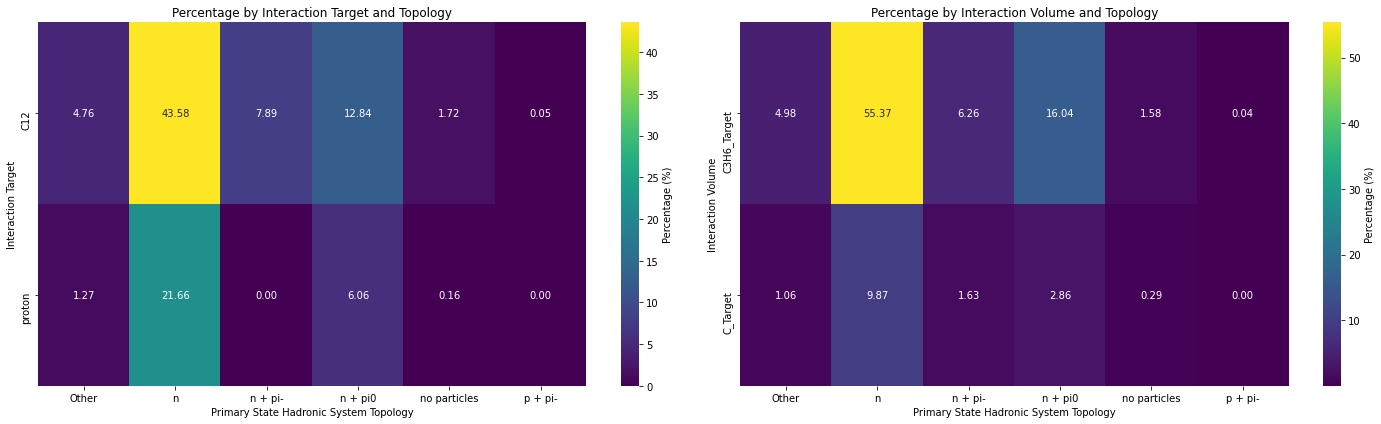

In [25]:
total_entries = len(selected_bkg)

# Creazione della prima pivot table per la percentuale in base a InteractionTarget e PrimaryStateHadronicSystemTopology_name
pivot1 = selected_bkg.pivot_table(columns='PrimaryStateHadronicSystemTopology_name', 
                        index='InteractionTarget', 
                        aggfunc='size', 
                        fill_value=0) / total_entries * 100

# Creazione della seconda pivot table per la percentuale in base a InteractionVolume_short e PrimaryStateHadronicSystemTopology_name
pivot2 = selected_bkg.pivot_table(columns='PrimaryStateHadronicSystemTopology_name', 
                        index='InteractionVolume_short', 
                        aggfunc='size', 
                        fill_value=0) / total_entries * 100

# Imposta il layout del grafico con 2 subplot affiancati
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Prima heatmap
sns.heatmap(pivot1, ax=axes[0], cmap='viridis',annot=True, fmt=".2f", cbar_kws={'label': 'Percentage (%)'})
axes[0].set_title("Percentage by Interaction Target and Topology")
axes[0].set_xlabel("Primary State Hadronic System Topology")
axes[0].set_ylabel("Interaction Target")

# Seconda heatmap
sns.heatmap(pivot2, ax=axes[1], cmap='viridis', annot=True, fmt=".2f", cbar_kws={'label': 'Percentage (%)'})
axes[1].set_title("Percentage by Interaction Volume and Topology")
axes[1].set_xlabel("Primary State Hadronic System Topology")
axes[1].set_ylabel("Interaction Volume")

# Adatta il layout per migliore visibilità
plt.tight_layout()
plt.show()


In [29]:
random_spill_trajectory_points.loc[0]

trackid  pdg     point_x      point_y       point_z    point_px  \
index                                                                    
0            0   13  594.410936 -3430.433643  23725.094274 -587.419022   
1            0   13  590.003925 -3427.364318  23754.689095 -586.793352   
2            0   13  589.734311 -3427.178510  23756.500000 -586.809011   
3            0   13  589.731334 -3427.176455  23756.520000 -586.730510   
4            0   13  586.003158 -3424.616535  23781.580000 -586.156417   
...        ...  ...         ...          ...           ...         ...   
11809     1735   11  380.900237 -3332.296848  25186.015581   -0.000000   
11810     1736   11  380.125146 -3332.453745  25185.983483   -0.028891   
11811     1736   11  380.112449 -3332.453243  25185.989410   -0.000000   
11812     1737   11  534.057918 -3392.117427  24133.323536    0.017548   
11813     1737   11  534.067606 -3392.118493  24133.306374    0.000000   

         point_py     point_pz  process pdg_name  
index                                             
0      411.846110  3940.635789      0.0     muon  
1      405.884944  3941.149050      2.0     muon  
2      405.569573  3941.179185      1.0     muon  
3      405.548205  3941.190601      1.0     muon  
4      400.079166  3940.910509      1.0     muon  
...           ...          ...      ...      ...  
11809   -0.000000     0.000000      2.0      e+-  
11810    0.001674     0.013436      2.0      e+-  
11811    0.000000     0.000000      2.0      e+-  
11812   -0.003474    -0.030961      2.0      e+-  
11813   -0.000000    -0.000000      2.0      e+-  

[11814 rows x 10 columns]

In [26]:
cells_fired_by_one_trajectory.dataframe

spill_number  cell_mod  cell_id        cell_x   cell_y  \
spill index                                                           
0     0                 6        40   140002 -1.712000e+03 -2384.73   
      1                 6        40   140003 -1.712000e+03 -2384.73   
      2                 6        40   140011 -1.712000e+03 -2384.73   
      3                 6        40   140110 -1.756000e+03 -2384.73   
      4                 6         0   200005  4.696243e-13  -362.73   
...                   ...       ...      ...           ...      ...   
89    831               8        30   330402  1.893000e+03 -2384.73   
      832               8        30   330404  1.893000e+03 -2384.73   
      833               8        30   330405  1.893000e+03 -2384.73   
      834               8        30   330406  1.893000e+03 -2384.73   
      835               8        30   330407  1.893000e+03 -2384.73   

                   cell_z  is_complete  track_id_pmt1_hit  track_id_pmt2_hit  \
spill index                                                                    
0     0      22021.111111            1                334                334   
      1      22065.555556            0                334                334   
      2      22421.111111            1                334                334   
      3      22376.666667            1                334                334   
      4      23932.120688            1                130                130   
...                   ...          ...                ...                ...   
89    831    25798.888889            1                169                169   
      832    25710.000000            1                 34                 34   
      833    25665.555556            0                 34                 34   
      834    25621.111111            1                416                416   
      835    25576.666667            1                 59                 59   

            track_pdg_pmt1_hit  ...  true_hit2_y   true_hit2_z  true_hit2_t  \
spill index                     ...                                           
0     0                   pi+-  ... -2655.906965  22027.419432  7080.948511   
      1                   pi+-  ...  -999.000000   -999.000000  -999.000000   
      2                   pi+-  ... -2401.103454  22402.384452  7149.294908   
      3                   pi+-  ... -2397.070657  22382.690335  7156.808452   
      4                 photon  ...  -380.934529  23934.023039  3922.552772   
...                        ...  ...          ...           ...          ...   
89    831              neutron  ... -2236.487863  25786.709814  3512.324511   
      832              neutron  ... -1740.980223  25698.561001  2251.686511   
      833              neutron  ...  -999.000000   -999.000000  -999.000000   
      834                 pi+-  ... -2444.574364  25602.856287  6475.969764   
      835              neutron  ... -1403.769025  25584.350224  2017.201463   

             true_edep1  true_edep2   reco_hit_x   reco_hit_y    reco_hit_z  \
spill index                                                                   
0     0        1.077140    1.077140 -1712.000000 -2375.405400  22021.111111   
      1     -999.000000 -999.000000  -999.000000  -999.000000   -999.000000   
      2        0.699242    0.699242 -1712.000000 -2342.083249  22421.111111   
      3        0.330639    0.330639 -1756.000000 -2412.948283  22376.666667   
      4        0.115499    0.115499    87.062821  -362.730000  23932.120688   
...                 ...         ...          ...          ...           ...   
89    831      0.062382    0.062382  1893.000000 -2451.448497  25798.888889   
      832      0.223657    0.223657  1893.000000 -2288.019049  25710.000000   
      833   -999.000000 -999.000000  -999.000000  -999.000000   -999.000000   
      834      0.289397    0.289397  1893.000000 -2297.669893  25621.111111   
      835      0.451562    0.451562  1893.000000 -2276.697156  25576.666

In [56]:
plot_event3D(df_selected_bkg = selected_bkg, 
             file_selected_background = "events-in-SANDtracker.4400.gtrac.root:gRooTracker:26", 
             fired_cells = cells_fired_by_one_trajectory.dataframe,
             random_spill_trajectory_points=random_spill_trajectory_points,
             spill_number=3,
             plot_hit_true=True)

Calculate expected neutron
read event trajectories
read fired wires
CCQEonHydrogen                                        0
EventType                                           QES
NuDirectionfX                               -0.00334051
NuDirectionfY                                 -0.101052
NuDirectionfZ                                  0.994876
Interaction_vtxX                               -1.29394
Interaction_vtxY                               -2.09542
Interaction_vtxZ                                22.9235
Interaction_vtxT                            1.41993e-09
InteractionVolume_short                     C3H6_Target
NofFinalStateChargedParticles                         1
PrimaryStateHadronicSystemTopology_name               n
InteractionTarget                                   C12
candidate_signal_event                                0
nof_fired_wires                                     218
PredictedNeutron_P3_GeVfX                    -0.0141685
PredictedNeutron_P3_GeVfY           

In [39]:
random_spill_trajectory_points

trackid  pdg      point_x      point_y       point_z    point_px  \
spill index                                                                     
0     0            0   13   594.410936 -3430.433643  23725.094274 -587.419022   
      1            0   13   590.003925 -3427.364318  23754.689095 -586.793352   
      2            0   13   589.734311 -3427.178510  23756.500000 -586.809011   
      3            0   13   589.731334 -3427.176455  23756.520000 -586.730510   
      4            0   13   586.003158 -3424.616535  23781.580000 -586.156417   
...              ...  ...          ...          ...           ...         ...   
89    56211     6750   11 -1149.933938 -1963.499821  21744.014260    0.660194   
      56212     6750   11 -1150.069976 -1965.029213  21746.098318    0.763608   
      56213     6750   11 -1149.273882 -1965.593036  21745.901411    0.550105   
      56214     6750   11 -1149.255948 -1964.827663  21745.887121   -1.189662   
      56215     6750   11 -1151.578197 -1963.602542  21745.268547   -0.000000   

               point_py     point_pz  process pdg_name  
spill index                                             
0     0      411.846110  3940.635789      0.0     muon  
      1      405.884944  3941.149050      2.0     muon  
      2      405.569573  3941.179185      1.0     muon  
      3      405.548205  3941.190601      1.0     muon  
      4      400.079166  3940.910509      1.0     muon  
...                 ...          ...      ...      ...  
89    56211   -2.790558     7.146599      2.0      e+-  
      56212   -3.867984     4.372915      2.0      e+-  
      56213   -1.317386    -3.281435      2.0      e+-  
      56214    1.963759     0.144688      2.0      e+-  
      56215   -0.000000    -0.000000      2.0      e+-  

[3699700 rows x 10 columns]

In [16]:
cells_fired_by_one_trajectory.dataframe.columns

Index(['spill_number', 'cell_mod', 'cell_id', 'cell_x', 'cell_y', 'cell_z',
       'is_complete', 'track_id_pmt1_hit', 'track_id_pmt2_hit',
       'track_pdg_pmt1_hit', 'track_pdg_pmt2_hit', 'true_hit1_x',
       'true_hit1_y', 'true_hit1_z', 'true_hit1_t', 'true_hit2_x',
       'true_hit2_y', 'true_hit2_z', 'true_hit2_t', 'true_edep1', 'true_edep2',
       'reco_hit_x', 'reco_hit_y', 'reco_hit_z', 'reco_hit_t', 'reco_edep'],
      dtype='object')

(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        3.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 2.806e+03, 0.000e+00,
        0.000e+00, 1.000e+00, 4.000e+00, 0.000e+00, 1.000e+00, 2.000e+00,
        2.000e+00, 0.000e+00, 1.000e+0

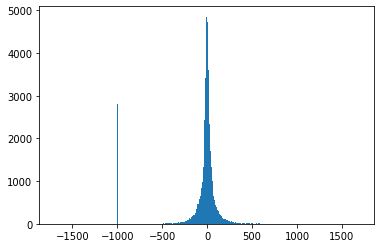

In [17]:
plt.hist(cells_fired_by_one_trajectory.dataframe.reco_hit_x, bins=np.arange(-1700,1700,10))